### TITLE : Intraday Resistance Breakout

<p> Author : BRYAN LIM YUQIANG </p> 
<p> Contact me : </p>
<li>Bryanlimyuqiang@gmail.com</li>
<li><a href = "https://www.linkedin.com/in/bryanlimyuqiang/">Linkedin </a></li> 
<li><a href = "https://www.etoro.com/people/bryanlimyuqiang"> Follow my trading journey </a></li>


<img src='./images/resistance_breakout.jpg' />

<img src='./images/resistance_example.jpg' />

In [4]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy

In [5]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78) #78 , 5 mins session per trading day 
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [8]:
# Download historical data (monthly) for selected stocks

tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM"]

ohlc_intraday = {} # directory with ohlc value for each stock            
key_path = "C:\\Users\\Gigabyte\\Desktop\\quant-trading-python-bot\\AlphaVantage_API.txt"
ts = TimeSeries(key=open(key_path,'r').read(), output_format='pandas')

attempt = 0 # initialising passthrough variable
drop = [] # initialising list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <=5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i],interval='5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ["Open","High","Low","Adj Close","Volume"]
            drop.append(tickers[i])      
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1

 
tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data


In [9]:
################################Backtesting####################################

# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  FB
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  INTC
calculating ATR and rolling max price for  CSCO
calculating ATR and rolling max price for  VZ
calculating ATR and rolling max price for  IBM


In [11]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            
            # SIGNAL IDENTIFICATION , if High price > rolling max closing price & Volume
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            
            # Difference between the previous close and the existing close  and close price - ATR
            if ohlc_dict[ticker]["Adj Close"][i]<ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                #rolling stop loss
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Adj Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Adj Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i]/ohlc_dict[ticker]["Adj Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["Adj Close"][i]>ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/(ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/(ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/ohlc_dict[ticker]["Adj Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  FB
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM


In [12]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

0.006116260058225627

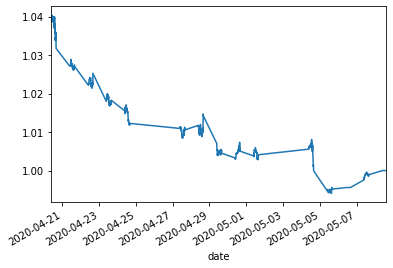

In [14]:
# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot() 
#performance of resistance breakout over the past 20 days of intraday trades

In [15]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

# Annualised Performance comparison, this does not take into account trading costs and slippage
    
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM


,Return,Sharpe Ratio,Max Drawdown
MSFT,0.740102,6.384340,0.014113
AAPL,1.426256,11.815113,0.010341
FB,3.630075,11.015956,0.033646
AMZN,-0.264329,-1.860228,0.026576
INTC,1.120426,6.634278,0.034058
CSCO,2.964345,17.073870,0.020772
VZ,0.435739,4.505952,0.014687
IBM,-0.059280,-0.866565,0.030371
